In [1]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as P
from scipy import stats
from sklearn import decomposition as decomp
import os

import textwrap

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import walnut_utils as wnut
from importlib import reload

In [2]:
iniN = 3
endN = 52

src = '../hpcc/traditional/'
dst = '../hpcc/results/trad/'

filename = src + 'traditional_phenotype_summary.csv'
df = pd.read_csv(filename, dtype={1:str})
print(df.shape)

filename = src + 'col_labels.csv'
labels = pd.read_csv(filename, dtype=str, keep_default_na = False)
print(labels.shape)

ids = df['UCACCSD'][~df['UCACCSD'].isna()].sort_values().unique()
N = len(ids)
M = endN - iniN
len(ids)

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

(1264, 52)
(67, 2)


In [3]:
idf = [None for i in range(len(ids))]
lens = np.zeros(len(idf), dtype=int)
i = 0
print(ids[i])
for i in range(len(idf)):
    idf[i] = df[ df['UCACCSD'] == ids[i] ].iloc[:, iniN:].values
    lens[i] = len(idf[i])

03-001-3395


In [4]:

f_oneway = np.zeros((N, 2))
kruskal = np.zeros_like(f_oneway)
agovern = np.zeros_like(kruskal)

for idx in range(idf[0].shape[1]):
    traits = [None for i in range(len(idf))]
    for i in range(len(traits)):
        traits[i] = idf[i][:, idx]
        
    f_oneway[idx] = np.asarray(stats.f_oneway(*traits))
    kruskal[idx] = np.asarray(stats.kruskal(*traits))
    foo = stats.alexandergovern(*traits)
    agovern[idx] = [foo.statistic, foo.pvalue]

In [5]:
filename = src + 'manwhitney_individuals.npy'

if not os.path.isfile(filename):

    manwhit = np.ones((M, N,N))

    traits = [None for i in range(len(idf))]

    for idx in range(M):
        for i in range(len(traits)):
            traits[i] = idf[i][:, idx]

        for i in range(N - 1):
            for j in range(i+1, N):
                manwhit[idx,i,j] = stats.mannwhitneyu(traits[i], traits[j]).pvalue

    manwhit *= N*(N-1)/2
    np.save(filename, manwhit)
    
else:
    manwhit = np.load(filename)
    
K = 2/(N*(N-1))
manwhit *= K
#manwhit = np.sum(manwhit, axis=1)
#K = 1
#manwhit = -np.log10(manwhit)

In [6]:
index = set()

idx = 20
print(labels.col_labels[iniN+idx], '\n--')
argsort = np.argsort(manwhit[idx], axis = None)

for i in range(np.sum(manwhit[idx] > 2 )):
    ix, jx = argsort[i]//N, argsort[i]%N
    index.add(ix); index.add(jx)
    #print(ix,jx,'\t{:02d}\t{:.3f}\t{} - {}'.format(i+1, manwhit[idx, ix,jx], ids[ix], ids[jx]))
index = np.sort(np.asarray(list(index)))
print(index.shape)

Shell Vol Ratio 
--
(0,)


In [7]:
ix, iy = sorted([65, 131])
print(ids[ix], ids[iy], sep='\t')
print(idf[ix][:,idx])
print(idf[iy][:,idx])

12-005-4	3
[0.13974168 0.11131597 0.09643177 0.11672288 0.12137327 0.11977198
 0.13341147 0.11234914]
[0.23375641 0.22252915 0.21417593 0.21405048 0.24526208 0.24088914
 0.22419222 0.26827435 0.22016074 0.22898261 0.25412788 0.2365011
 0.24901777]


In [8]:
print(stats.mannwhitneyu(idf[ix][:,idx], idf[iy][:,idx], method='exact'))
print(stats.mannwhitneyu(idf[iy][:,idx], idf[ix][:,idx], method='asymptotic'))
print(manwhit[idx, ix, iy])

MannwhitneyuResult(statistic=0.0, pvalue=9.828492800629024e-06)
MannwhitneyuResult(statistic=104.0, pvalue=0.00019173440637816532)
9.828492800629024e-06


ValueError: Dimensions of labels and X must be compatible

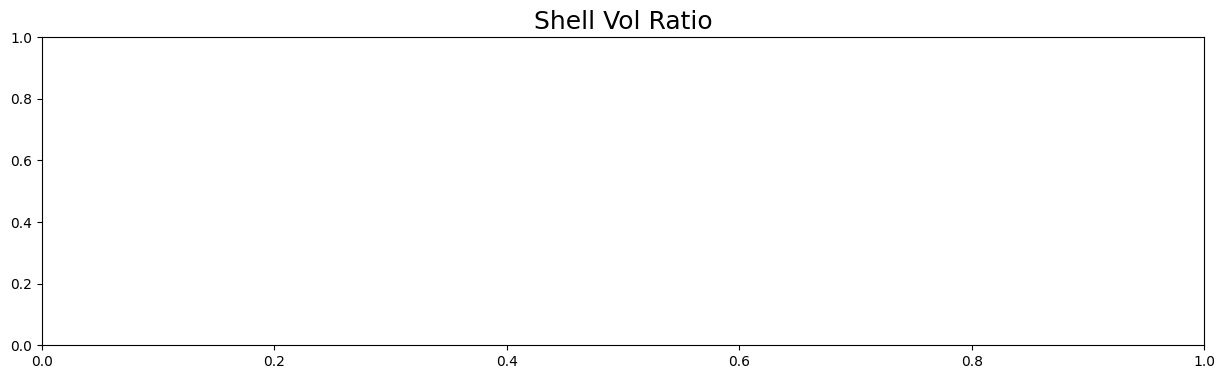

In [10]:
fs = 18
boxes = []

fig, ax = plt.subplots(1,1, figsize=(15,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(index)):
    boxes.append(idf[index[i]][:,idx])
#lable = ['{} ({})'.format(ids[i], lens[i]) for i in index]
lable = ['' for i in range(len(boxes))]

ax[0].set_title(labels.col_labels[iniN+idx], fontsize=fs)
ax[0].boxplot(boxes, labels=lable, patch_artist=True, sym='');
#ax[0].tick_params('x', rotation=90);

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(manwhit[idx].T, cmap='Blues', vmin=0, vmax=2);

# ANOVA

In [ ]:
signif = np.zeros(M)
for idx in range(M):
    signif[idx] = np.sum(manwhit[idx] > 2)*K
arg = np.argsort(signif)[::-1]

In [ ]:
reltraits = np.array([24,23,21,26,51,49,13,14]) - iniN

for idx in reltraits:
    print(idx, np.round(signif[idx]*100,2), arg[idx] + 1, sep='\t')

In [ ]:
np.round(signif*100, 2)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].scatter(range(M), np.sort(signif), marker='o')

In [ ]:
idx = 18

fmanwhit = manwhit[idx] + manwhit[idx].T
percdiff = np.zeros(len(fmanwhit))

for i in range(len(fmanwhit)):
    percdiff[i] = np.sum(fmanwhit[i] > 2)
percdiff *= 1/(len(fmanwhit) - 1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].bar(range(len(fmanwhit)), np.sort(percdiff));
ax[0].set_title(labels.col_labels[iniN+idx], fontsize=fs);
ax[0].axhline(0.5, c='red');

# Now fix the variety

In [ ]:
diffacc = np.zeros((N, M))
diffscore = np.zeros((N,2))
wid =141

for wid in range(N):
    for i in range(wid):
        diffacc[i] = manwhit[:, i, wid]
    for i in range(wid, N):
        diffacc[i] = manwhit[:, wid, i]
    
    for i in range(2):
        diffscore[wid,i] = np.mean(np.sum(diffacc > 2, axis=i))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,4), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].scatter(range(N),diffscore[:,i], marker='o')
    ax[i].axvline(141, c='red');
    ax[i].axhline(diffscore[141, i], c='red')
    
ax[0].set_xlabel('Accession index', fontsize=fs)
ax[0].set_ylabel('Average no. of statistically\ndifferent accessions', fontsize=fs);

# Z-score

In [11]:
x = np.linspace(stats.norm.ppf(0.002), stats.norm.ppf(0.998), 100)
norm = stats.norm.pdf(x)

In [12]:
easyopen = ['08-019-11', '09-025-99', '10-001-6', '10-005-3', '11-020-2',
       '12-002-17', '12-002-21', '12-002-26', '12-002-28', '12-005-4',
       '12-005-5', '12-045-11', '12-045-12', '12-045-15']

easywid = [np.nonzero(ids == easyopen[i]) for i in range(len(easyopen))]
easywid = np.array(easywid).squeeze()

hardopen = ['12-002-10', '12-004-1']
hardwid = [np.nonzero(ids == hardopen[i]) for i in range(len(hardopen))]
hardwid = np.array(hardwid).squeeze()

earopen = ['85-023-2']
earwid = 141

In [13]:
from sklearn import preprocessing as prep

means = np.zeros((len(ids), M))
stds = np.zeros_like(means)
qcd = np.zeros_like(means)
cv = np.zeros_like(means)

for i in range(len(ids)):
    himalaya = df[df.UCACCSD == ids[i]]
    describe = himalaya.iloc[:,iniN:endN].describe().drop(index=['count']).T
    means[i] = describe['mean'].values
    stds[i] = describe['std'].values
    qcd[i] = (describe['75%'] - describe['25%'])/(describe['75%'] + describe['25%'])
    cv[i] = stds[i]/means[i]
    
X = prep.StandardScaler().fit_transform(means.copy())

In [14]:
interest = np.asarray([21,23,24,51,49,26]) - iniN

In [22]:
summeans = np.zeros((len(means), 2))
#summeans[:,0] = np.mean(np.abs(X[:,interest]), axis=1)
#summeans[:,1] = np.mean(qcd[:, interest], axis=1)

summeans[:,0] = np.mean(np.abs(X), axis=1)
summeans[:,1] = np.mean(qcd, axis=1)

../hpcc/results/trad/overall_distribution_85-023-2_vs_rest


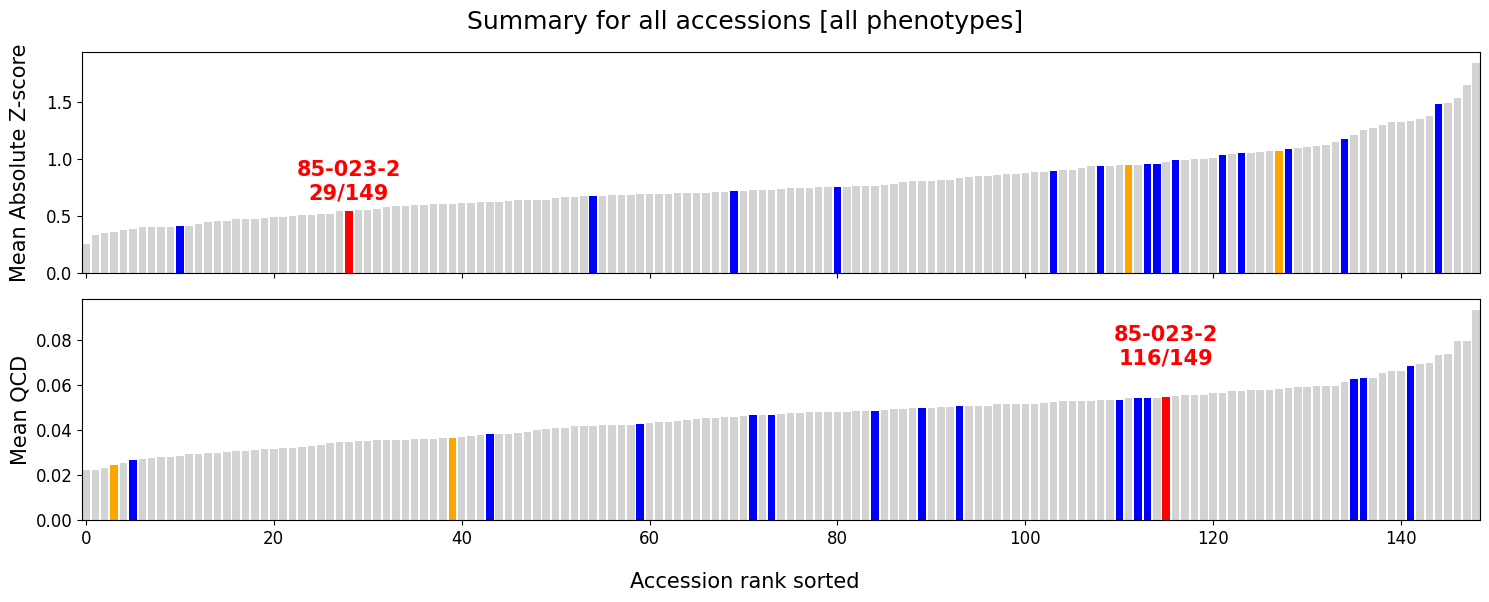

In [44]:
fs = 15
ylabel = ['Mean Absolute Z-score', 'Mean QCD']

fig, ax = plt.subplots(2,1, figsize=(15,6), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel(); i=0

wid = earwid
wwd = easywid[0]

for i in range(len(ax)):
    foo = np.min(summeans[:,i])
    arg = np.argsort(summeans[:,i])
    rnk = np.argsort(arg)

    ax[i].bar(range(len(summeans)), summeans[arg,i], color='lightgray', zorder=1);
    ax[i].bar(rnk[easywid], summeans[easywid,i], color='blue', zorder=2)
    ax[i].bar(rnk[earwid], summeans[earwid,i], color='red', zorder=3)
    ax[i].bar(rnk[hardwid], summeans[hardwid,i], color='orange', zorder=2)
    ax[i].set_ylabel(ylabel[i], fontsize=fs)
    ax[i].tick_params(labelsize=fs-3)
    ax[i].text(rnk[wid], summeans[wid,i]+foo, '{}\n{}/{}'.format(ids[wid], rnk[wid]+1,len(summeans)),
                       ha="center", va="center", color='red', fontsize=fs, fontweight='bold')
    #ax[i].text(rnk[wwd], summeans[wwd,i]+foo, '{}\n{}/{}'.format(ids[wwd], rnk[wwd]+1,len(summeans)),
    #                   ha="center", va="center", color='blue', fontsize=fs, fontweight='bold')
    ax[i].margins(x=0)
    #ax[i].set_xticks([rnk[wid]], [rnk[wid]+1], color='r')
    
#ax[0].set_yticks(np.linspace(0,1.5,4))

fig.align_ylabels()
fig.supxlabel('Accession rank sorted', fontsize=fs)
fig.suptitle('Summary for all accessions [all phenotypes]', fontsize=fs+3)
fig.tight_layout();

filename = dst + 'overall_distribution_' + ids[wid] + '_vs_rest'
print(filename)
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')
plt.savefig(filename + '.svg', bbox_inches='tight', format='svg')

In [29]:
X.shape

(1264, 49)

../hpcc/results/trad/all_phenotype_distribution


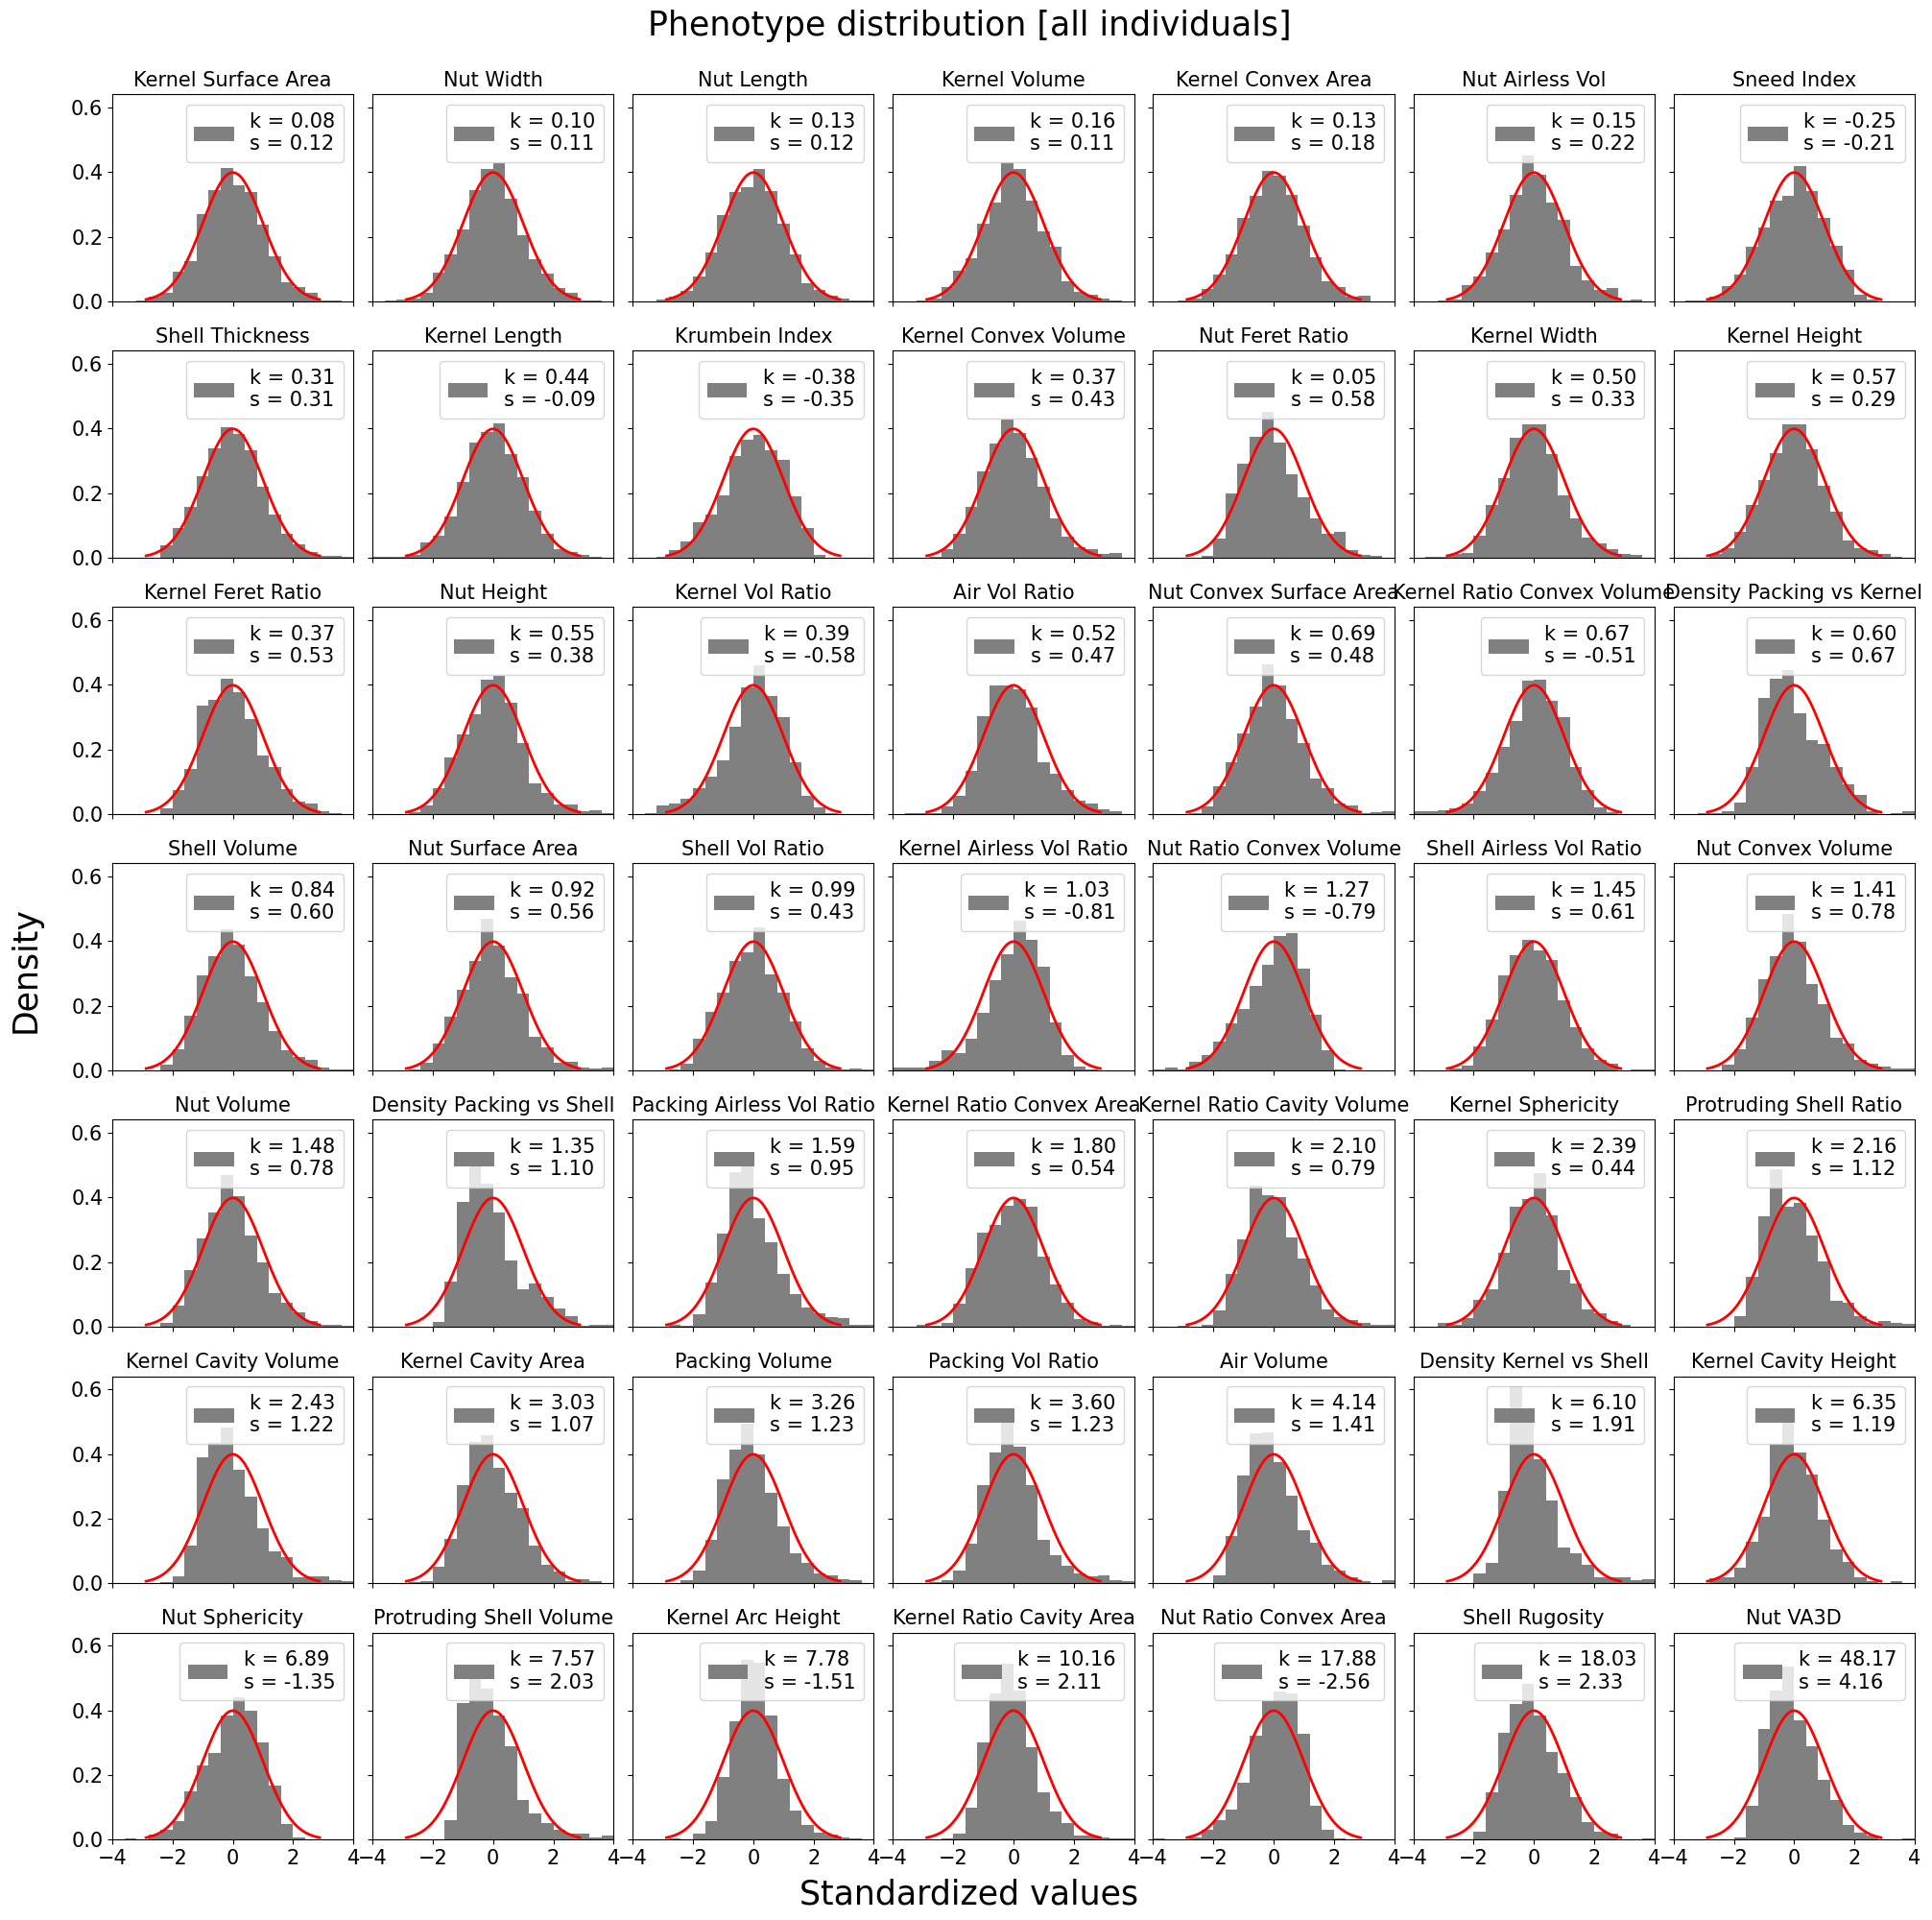

In [31]:
X = prep.StandardScaler().fit_transform(df.iloc[:,iniN:endN].values.copy())
kurt = stats.kurtosis(X, axis=0)
skew = stats.skew(X, axis=0)

arg = np.argsort(skew**2 + kurt**2)

fs = 15
K = 4
fig, ax = plt.subplots(7,7, figsize=(20,20), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].set_xlim((-K,K))
    ax[i].hist(X[:,arg[i]], bins=20, range=(-K,K), density=True, color='gray', zorder=1, 
               label='k = {:.2f}\ns = {:.2f}'.format(kurt[arg[i]], skew[arg[i]]));
    ax[i].plot(x, norm, color='red', zorder=3, lw=2);
    ax[i].set_title(labels.col_labels.iloc[iniN + arg[i]], fontsize=fs)
    ax[i].legend(fontsize=fs)
    ax[i].tick_params(labelsize=fs)

#fig.delaxes(ax[-1])
fig.supxlabel('Standardized values', fontsize=fs+10)
fig.supylabel('Density', fontsize=fs+10, x=0)
fig.suptitle('Phenotype distribution [all individuals]', fontsize=fs+10, y=1)

fig.tight_layout()

filename = dst + 'all_phenotype_distribution'
print(filename)
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')
plt.savefig(filename + '.svg', bbox_inches='tight', format='svg')

../hpcc/results/trad/average_z-score_select


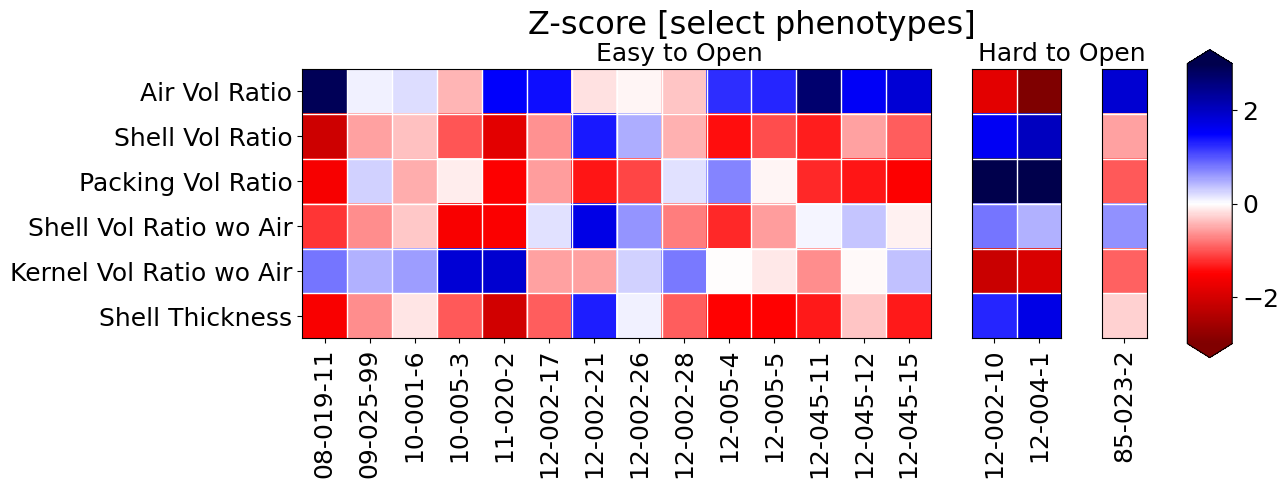

In [62]:
fs = 18

fig, ax = plt.subplots(1,4, figsize=(12,4), sharex=False, sharey=False, width_ratios=[14,2,1,1])
ax = np.atleast_1d(ax).ravel()

im = ax[0].imshow(X[easywid,:][:, interest].T, cmap='seismic_r', vmin=-3, vmax=3);
im = ax[1].imshow(X[hardwid,:][:, interest].T, cmap='seismic_r', vmin=-3, vmax=3);
im = ax[2].imshow(X[earwid][interest].reshape(-1,1), cmap='seismic_r', vmin=-3, vmax=3);

ax[0].set_title('Easy to Open', fontsize=fs, x=0.6)
ax[0].set_yticks(range(len(interest)), labels.col_labels.iloc[iniN:endN].iloc[interest], fontsize=fs)
ax[0].set_xticks(range(len(easyopen)), easyopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)

ax[1].set_title('Hard to Open', fontsize=fs, x=1)
ax[1].set_xticks(range(len(hardopen)), hardopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)
ax[2].set_xticks(range(len(earopen)), earopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)

for i in range(1,len(ax)):
    ax[i].tick_params('y', left=False, labelleft=False)
    
for i in range(len(ax)-1):
    for j in range(len(interest)-1):
        ax[i].axhline(j+.5, c='w', lw=1)
        
for j in range(len(easyopen)-1):
    ax[0].axvline(j+.5, c='w', lw=1)
ax[1].axvline(.5, c='w', lw=1)

fig.colorbar(im, cax=ax[3], extend='both')
ax[3].tick_params(labelsize=fs)
fig.suptitle('Z-score [select phenotypes]', fontsize=fs+5, x=0.5)
#fig.tight_layout();

filename = dst + 'average_z-score_select'
print(filename)
plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=200, format='jpg', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

../hpcc/results/trad/standard_dev_z-score_select


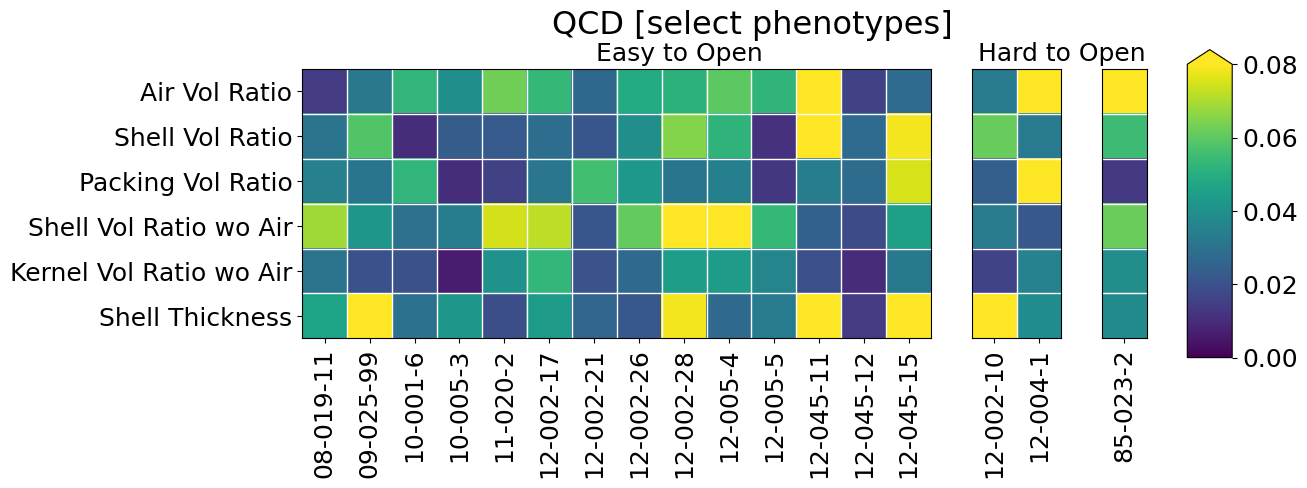

In [65]:
fs = 18

fig, ax = plt.subplots(1,4, figsize=(12,4), sharex=False, sharey=False, width_ratios=[14,2,1,1])
ax = np.atleast_1d(ax).ravel()

im = ax[0].imshow(qcd[easywid,:][:, interest].T, cmap='viridis', vmin=0, vmax=0.08);
im = ax[1].imshow(qcd[hardwid,:][:, interest].T, cmap='viridis', vmin=0, vmax=0.08);
im = ax[2].imshow(qcd[earwid][interest].reshape(-1,1), cmap='viridis', vmin=0, vmax=0.08);

ax[0].set_title('Easy to Open', fontsize=fs, x=0.6)
ax[0].set_yticks(range(len(interest)), labels.col_labels.iloc[iniN:endN].iloc[interest], fontsize=fs)
ax[0].set_xticks(range(len(easyopen)), easyopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)

ax[1].set_title('Hard to Open', fontsize=fs, x=1)
ax[1].set_xticks(range(len(hardopen)), hardopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)
ax[2].set_xticks(range(len(earopen)), earopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)

for i in range(1,len(ax)):
    ax[i].tick_params('y', left=False, labelleft=False)
    
for i in range(len(ax)-1):
    for j in range(len(interest)-1):
        ax[i].axhline(j+.5, c='w', lw=1)
        
for j in range(len(easyopen)-1):
    ax[0].axvline(j+.5, c='w', lw=1)
ax[1].axvline(.5, c='w', lw=1)

fig.colorbar(im, cax=ax[3], extend='max')
ax[3].tick_params(labelsize=fs)
fig.suptitle('QCD [select phenotypes]', fontsize=fs+5, x=0.5)
#fig.tight_layout();

filename = dst + 'standard_dev_z-score_select'
print(filename)
plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=200, format='jpg', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

Text(0.5, 0.98, 'Z-score [select phenotypes]')

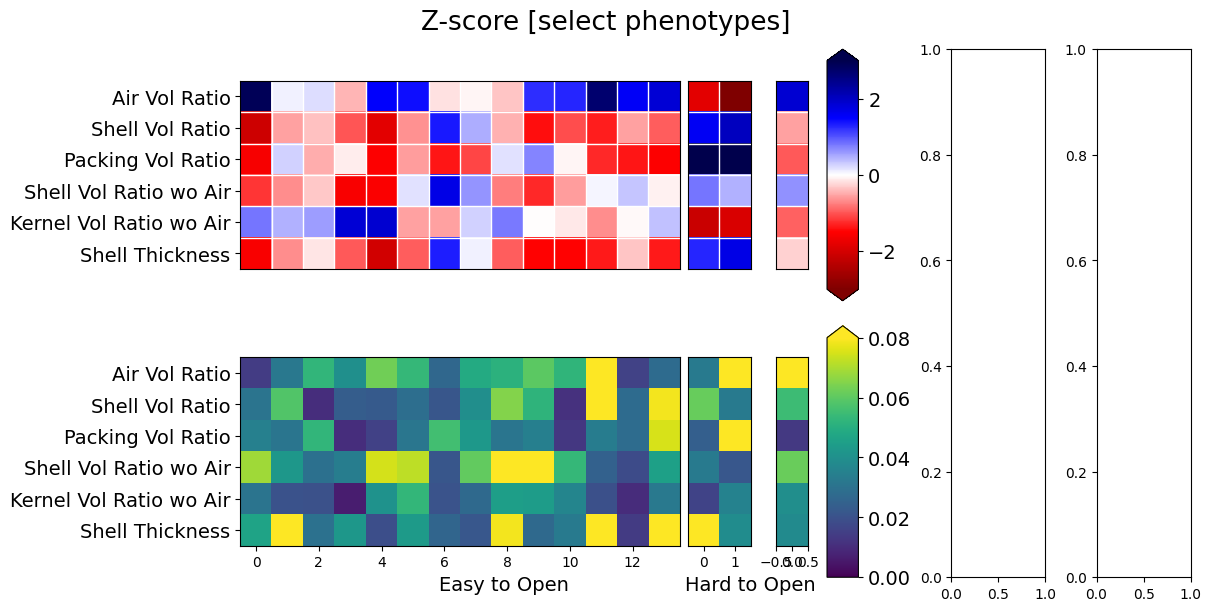

In [56]:
fig = plt.figure(layout="constrained", figsize=(12,6))

gs = GridSpec(2, 24, figure=fig)

ax1 = fig.add_subplot(gs[0, :14])
ax2 = fig.add_subplot(gs[0, 14:16])
ax3 = fig.add_subplot(gs[0, 16])
ax4 = fig.add_subplot(gs[0, 17])

ax5 = fig.add_subplot(gs[1, :14])
ax6 = fig.add_subplot(gs[1, 14:16])
ax7 = fig.add_subplot(gs[1, 16])
ax8 = fig.add_subplot(gs[1, 17])

ax9 = fig.add_subplot(gs[:, 18:21])
ax0 = fig.add_subplot(gs[:, 21:])

ax = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax0]

im = ax[0].imshow(X[easywid,:][:, interest].T, cmap='seismic_r', vmin=-3, vmax=3);
im = ax[1].imshow(X[hardwid,:][:, interest].T, cmap='seismic_r', vmin=-3, vmax=3);
im = ax[2].imshow(X[earwid][interest].reshape(-1,1), cmap='seismic_r', vmin=-3, vmax=3);
fig.colorbar(im, cax=ax[3], extend='both')

im = ax[4].imshow(qcd[easywid,:][:, interest].T, cmap='viridis', vmin=0, vmax=0.08);
im = ax[5].imshow(qcd[hardwid,:][:, interest].T, cmap='viridis', vmin=0, vmax=0.08);
im = ax[6].imshow(qcd[earwid][interest].reshape(-1,1), cmap='viridis', vmin=0, vmax=0.08);
fig.colorbar(im, cax=ax[7], extend='max')

for i in [0,4]:
    ax[i].set_yticks(range(len(interest)), labels.col_labels.iloc[iniN:endN].iloc[interest], fontsize=fs)

ax[4].set_xlabel('Easy to Open', fontsize=fs, x=0.6)

for i in range(4):
    ax[i].set_xticks([])

ax[5].set_xlabel('Hard to Open', fontsize=fs, x=1)

for i in [1,2,3,5,6,7]:
    ax[i].tick_params('y', left=False, labelleft=False)
    
for i in range(3):
    for j in range(len(interest)-1):
        ax[i].axhline(j+.5, c='w', lw=1)
        
for j in range(len(easyopen)-1):
    ax[0].axvline(j+.5, c='w', lw=1)
ax[1].axvline(.5, c='w', lw=1)

for i in [3,7]:
    ax[i].tick_params(labelsize=fs)
fig.suptitle('Z-score [select phenotypes]', fontsize=fs+5, x=0.5)


In [37]:
pca = decomp.PCA(n_components=2, svd_solver='full')
pca.fit(X[:, interest])

print(100*pca.explained_variance_ratio_[:10])
print(pca.singular_values_[:10])
print(100*np.cumsum(pca.explained_variance_ratio_)[:10])

redux = pca.transform(X[:, interest])
print(redux.shape)

[63.36258631 22.02939856]
[23.80045213 14.03363186]
[63.36258631 85.39198487]
(149, 2)


In [38]:
XX = prep.StandardScaler().fit_transform(df.iloc[:,iniN:endN].values.copy())
pcax = decomp.PCA(n_components=2, svd_solver='full')
pcax.fit(XX[:, interest])

print(100*pcax.explained_variance_ratio_[:10])
print(pcax.singular_values_[:10])
print(100*np.cumsum(pcax.explained_variance_ratio_)[:10])

reduxx = pca.transform(XX[:, interest])
print(reduxx.shape)

[56.30411181 24.75882916]
[65.34603155 43.3325467 ]
[56.30411181 81.06294098]
(1264, 2)


In [39]:
easywno = []
for i in ids[easywid]:
    easywno = easywno + list(df[df.UCACCSD == i].index)
easywno = np.asarray(easywno)

hardwno = []
for i in ids[hardwid]:
    hardwno = hardwno + list(df[df.UCACCSD == i].index)
hardwno = np.asarray(hardwno)

earwno = []
for i in [ids[earwid]]:
    earwno = earwno + list(df[df.UCACCSD == i].index)
earwno = np.asarray(earwno)

foo=np.setxor1d(np.arange(len(reduxx)), np.hstack((easywno,hardwno,earwno)))

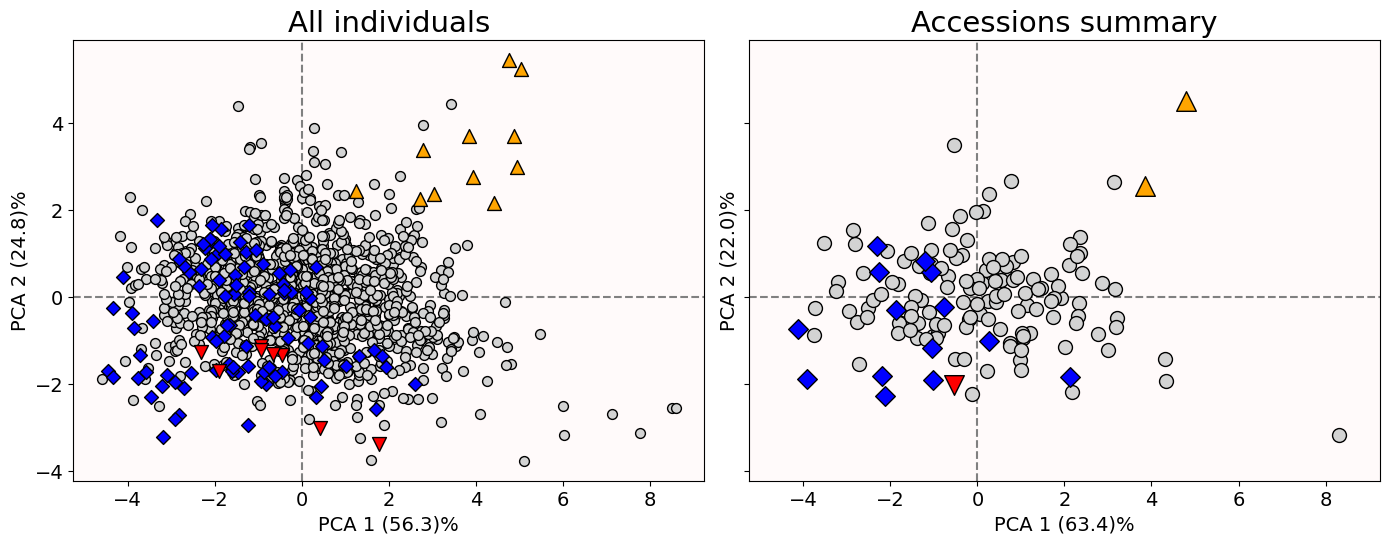

In [40]:
rxtech = "PCA"
fs = 14


fig, ax = plt.subplots(1,2, figsize=(14,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); idx = 1

foo=np.setxor1d(np.arange(len(redux)), np.hstack((easywid,hardwid,earwid)))
ax[idx].scatter(redux[foo,0], redux[foo,1], c = 'lightgray',
                s=100, alpha=1, edgecolors='k', zorder=2)
ax[idx].scatter(redux[easywid,0], redux[easywid,1], c = 'blue', marker='D',
                s=100, alpha=1, edgecolors='k', zorder=3)
ax[idx].scatter(redux[hardwid,0], redux[hardwid,1], c = 'orange', marker='^',
                s=200, alpha=1, edgecolors='k', zorder=4)
ax[idx].scatter(redux[earwid,0], redux[earwid,1], c = 'red', marker='v',
                s=200, alpha=1, edgecolors='k', zorder=4)
ax[idx].set_xlabel(rxtech + ' 1 ({:.1f})%'.format(pca.explained_variance_ratio_[0]*100), fontsize=fs)
ax[idx].set_ylabel(rxtech + ' 2 ({:.1f})%'.format(pca.explained_variance_ratio_[1]*100), fontsize=fs);
title = 'Accessions summary' 
ax[idx].set_title(title, fontsize=fs+7)

idx = 0
foo=np.setxor1d(np.arange(len(reduxx)), np.hstack((easywno,hardwno,earwno)))
ax[idx].scatter(reduxx[foo,0], reduxx[foo,1], c = 'lightgray',
                s=50, alpha=1, edgecolors='k', zorder=2)
ax[idx].scatter(reduxx[easywno,0], reduxx[easywno,1], c = 'blue', marker='D',
                s=50, alpha=1, edgecolors='k', zorder=3)
ax[idx].scatter(reduxx[hardwno,0], reduxx[hardwno,1], c = 'orange', marker='^',
                s=100, alpha=1, edgecolors='k', zorder=4)
ax[idx].scatter(reduxx[earwno,0], reduxx[earwno,1], c = 'red', marker='v',
                s=100, alpha=1, edgecolors='k', zorder=4)
ax[idx].set_xlabel(rxtech + ' 1 ({:.1f})%'.format(pcax.explained_variance_ratio_[0]*100), fontsize=fs)
ax[idx].set_ylabel(rxtech + ' 2 ({:.1f})%'.format(pcax.explained_variance_ratio_[1]*100), fontsize=fs);
title = 'All individuals' 
ax[idx].set_title(title, fontsize=fs+7)
    
for idx in range(len(ax)):
    ax[idx].set_aspect('equal')
    ax[idx].set_facecolor('snow')
    ax[idx].tick_params(labelsize=fs)
    ax[idx].axvline(0, c='gray', ls='--', zorder=1)
    ax[idx].axhline(0, c='gray', ls='--', zorder=1)
fig.tight_layout();

filename = dst + rxtech.lower() + '_all_phenos_'
#plt.savefig(filename + '.jpg', dpi=135, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')

../hpcc/results/trad/individual_distribution_91-136_vs_rest


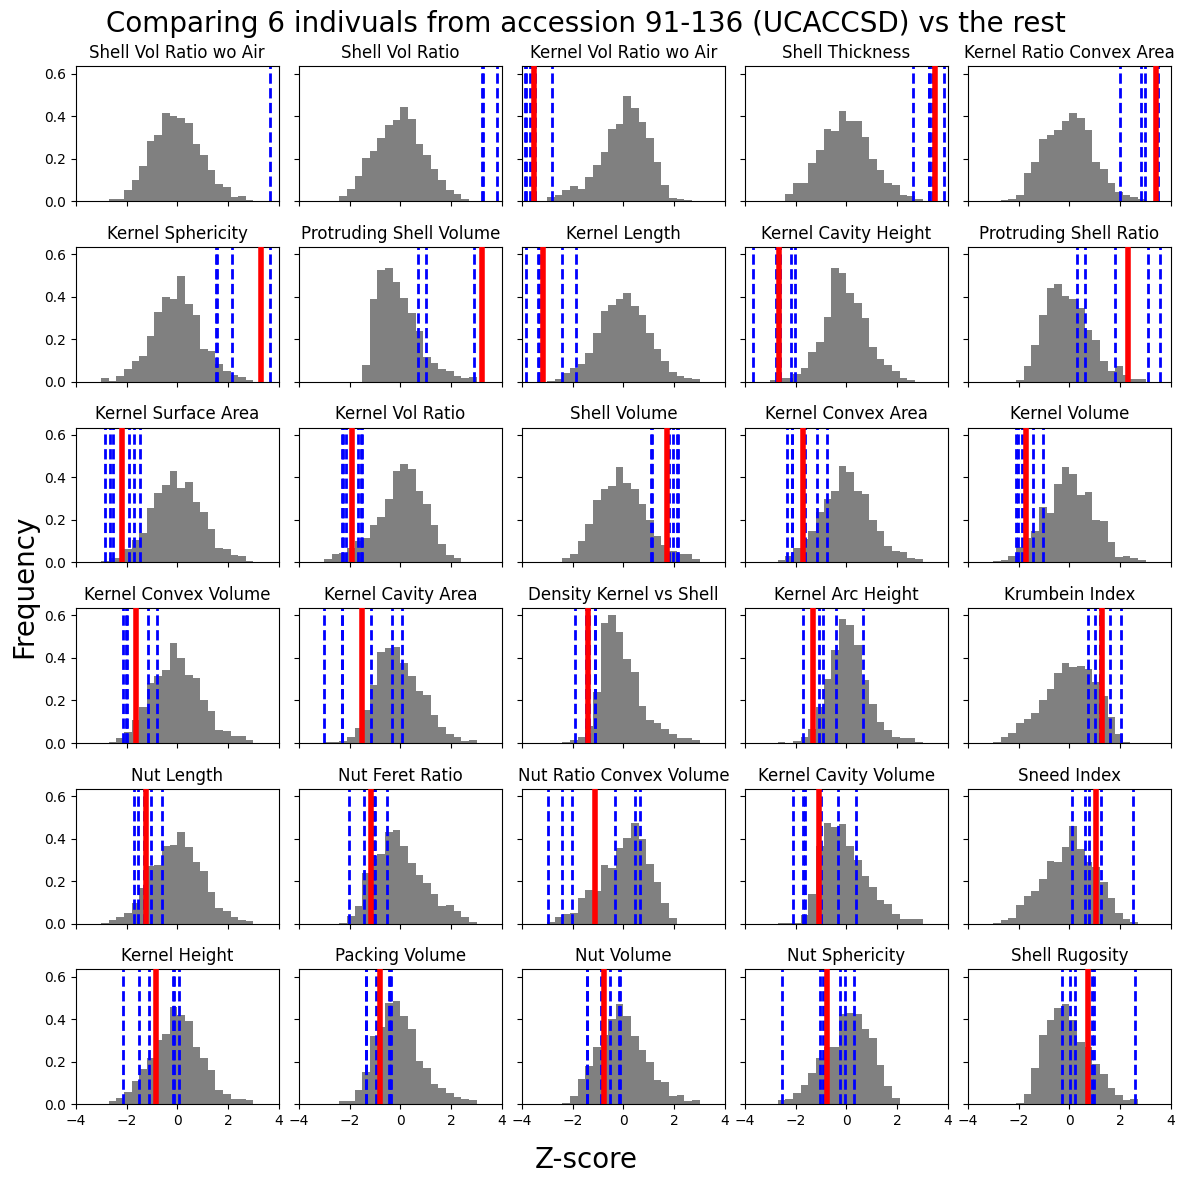

In [233]:
fs = 20

wid = np.argmax(summeans[:,1])
ucaccsd = ids[wid]
arg = np.argsort(np.abs(means[wid]))[::-1]

himalaya = df[df.UCACCSD == ucaccsd].index

print(wid, len(himalaya), summeans[wid])

fig, ax = plt.subplots(6,5, figsize=(12,12), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].set_xlim((-4,4))
    ax[i].hist(X[:,arg[i]], bins=20, range=(-3,3), density=True, color='gray', zorder=1);
    ax[i].axvline(means[wid,arg[i]], c='red', lw=4, zorder=3)
    for j in X[himalaya,arg[i]]:
        ax[i].axvline(j,c='blue',lw=2,ls='--', zorder=2)
    ax[i].set_title(labels.col_labels.iloc[iniN + arg[i]], fontsize=fs-8)

fig.suptitle('Comparing {} indivuals from accession '.format(len(himalaya)) + ucaccsd + ' (UCACCSD) vs the rest', fontsize=fs )
fig.supxlabel('Z-score', fontsize=fs)
fig.supylabel('Frequency', fontsize=fs)
fig.tight_layout()

filename = dst + 'individual_distribution_' + ucaccsd + '_vs_rest'
print(filename)
plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=200, format='jpg', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

# One vs all

In [32]:
filename = src + 'manwhitney_one_vs_all.npy'

if not os.path.isfile(filename):

    manwhit = np.ones((N,M))
    
    for i in range(N):
        ones = df[df.UCACCSD == ids[i]].iloc[:,iniN:].values
        rest = df[df.UCACCSD != ids[i]].iloc[:,iniN:].values
        
        for j in range(M):
            manwhit[i,j] = stats.mannwhitneyu(ones[:,j], rest[:,j], method='asymptotic').pvalue
    np.save(filename, manwhit)
    
else:
    manwhit = np.load(filename)
    
K = 1
#K = N*M
manwhit = -np.log10(manwhit*K)

../hpcc/results/trad/mannwhitney_pvals


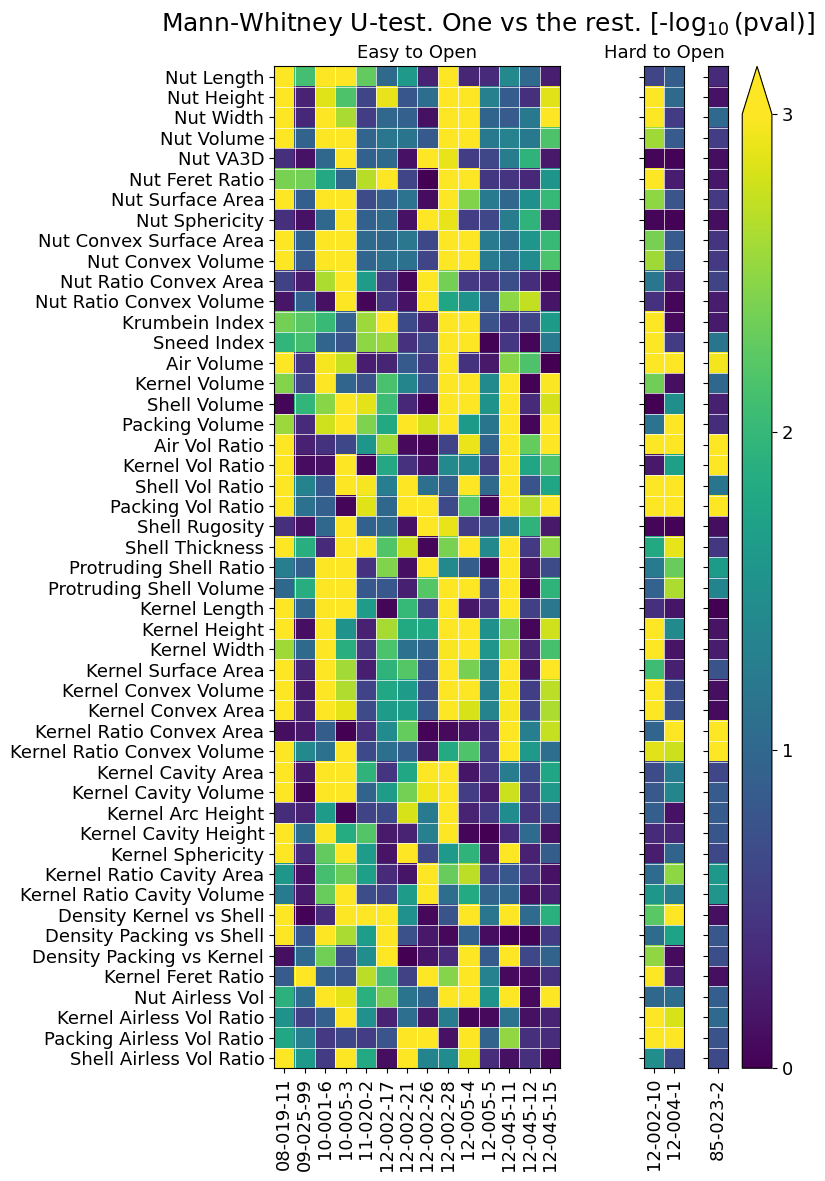

In [33]:
fs = 13

fig, ax = plt.subplots(1,4, figsize=(8,12), sharex=False, sharey=False, width_ratios=[14,2,1,1])
ax = np.atleast_1d(ax).ravel()

im = ax[0].imshow(manwhit[easywid, :].T, cmap='viridis', vmin=0, vmax=3);
im = ax[1].imshow(manwhit[hardwid, :].T, cmap='viridis', vmin=0, vmax=3);
im = ax[2].imshow(manwhit[earwid, :].reshape(-1,1), cmap='viridis', vmin=0, vmax=3);

ax[0].set_title('Easy to Open', fontsize=fs)
ax[0].set_yticks(range(M), labels.col_labels.iloc[iniN:endN], fontsize=fs)
ax[0].set_xticks(range(len(easyopen)), easyopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)

ax[1].set_title('Hard to Open', fontsize=fs)
ax[1].set_xticks(range(len(hardopen)), hardopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)
ax[2].set_xticks(range(len(earopen)), earopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)

for i in range(1,len(ax)):
    ax[i].set_yticks(range(M), [])

for i in range(len(easywid)-1):
    ax[0].axvline(i+.5, c='w', lw=.5)
ax[1].axvline(.5, c='w', lw=.5)

for i in range(3):
    for j in range(M-1):
        ax[i].axhline(j+.5, c='w', lw=.5)
    
fig.colorbar(im, cax=ax[3], extend='max', ticks=range(4))
ax[3].tick_params(labelsize=fs)
fig.suptitle('Mann-Whitney U-test. One vs the rest. [-$\log_{10}$(pval)]', fontsize=fs+5, x=0.6)
fig.tight_layout();

filename = dst + 'mannwhitney_pvals'
print(filename)
#plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=200, format='jpg', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

In [37]:
np.max(qcd)

0.8772126169375809

../hpcc/results/trad/trait_uniqueness_summary


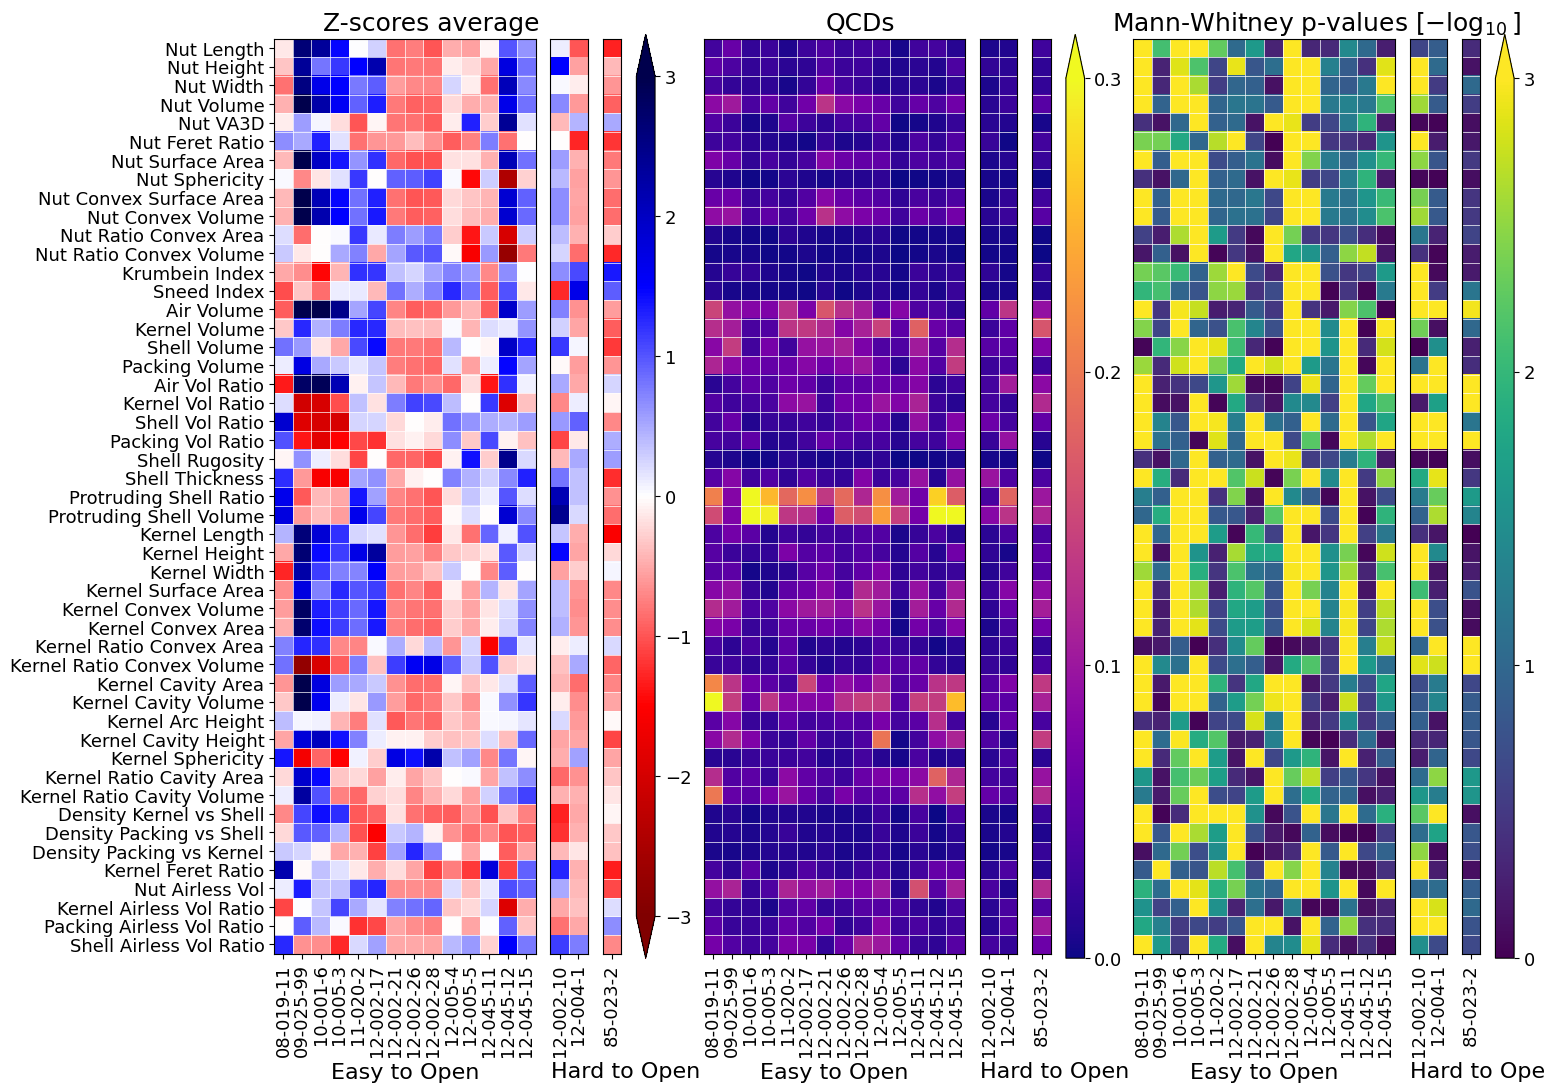

In [42]:
vmax = 0.3
fs = 13

fig, ax = plt.subplots(1,14, figsize=(16,12), sharex=False, sharey=False, 
                       width_ratios=[14,2,1,1,1,14,2,1,1,1,14,2,1,1], height_ratios=[1])
ax = np.atleast_1d(ax).ravel()

i = 0
im = ax[i].imshow(X[easywid, :].T, cmap='seismic_r', vmin=-3, vmax=3); i += 1
im = ax[i].imshow(X[hardwid, :].T, cmap='seismic_r', vmin=-3, vmax=3); i += 1
im0 = ax[i].imshow(X[earwid, :].reshape(-1,1), cmap='seismic_r', vmin=-3, vmax=3); i += 1
fig.colorbar(im0, cax=ax[i], extend='both', use_gridspec=False); i += 1
i += 1
im = ax[i].imshow(qcd[easywid, :].T, cmap='plasma', vmin=0, vmax=vmax); i += 1
im = ax[i].imshow(qcd[hardwid, :].T, cmap='plasma', vmin=0, vmax=vmax); i += 1
im = ax[i].imshow(qcd[earwid, :].reshape(-1,1), cmap='plasma', vmin=0, vmax=vmax); i += 1
fig.colorbar(im, cax=ax[i], extend='max', ticks=np.linspace(0,0.3,4), use_gridspec=True, pad=1); i += 1

i += 1
im = ax[i].imshow(manwhit[easywid, :].T, cmap='viridis', vmin=0, vmax=3); i += 1
im = ax[i].imshow(manwhit[hardwid, :].T, cmap='viridis', vmin=0, vmax=3); i += 1
im1 = ax[i].imshow(manwhit[earwid, :].reshape(-1,1), cmap='viridis', vmin=0, vmax=3); i += 1
fig.colorbar(im1, cax=ax[i], extend='max', ticks=range(4), use_gridspec=False); i += 1

ax[0].set_yticks(range(M), labels.col_labels.iloc[iniN:endN], fontsize=fs)

for i in [1,2,5,6,7,10,11,12]:
    ax[i].tick_params(left=False, labelleft=False)

lw = 0.5
    
for i in [0,2,5,6,7,10,11,12]:
    for j in range(M-1):
        ax[i].axhline(j+.5, c='w', lw=lw)

for i in [0,5,10]:
    for j in range(len(easyopen)-1):
        ax[i].axvline(j+.5, c='w', lw=lw)
    ax[i].set_xlabel('Easy to Open', fontsize=fs+3)
    ax[i].set_xticks(range(len(easyopen)), easyopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)

for i in [1,6,11]:
    ax[i].axvline(.5, c='w', lw=lw)
    ax[i].set_xlabel('Hard to Open', fontsize=fs+3, x=2)
    ax[i].set_xticks(range(len(hardopen)), hardopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)

for i in [2,7,12]:
    ax[i].set_xticks(range(len(earopen)), earopen, rotation=90, 
                 ha='right', va='center', rotation_mode='anchor', fontsize=fs)

for i in [3,8,13]:
    ax[i].tick_params(labelsize=fs)
    
for i in [4,9]:
    fig.delaxes(ax[i])
    
ax[0].set_title('Z-scores average', fontsize=fs+5, x=0.6)
ax[5].set_title('QCDs', fontsize=fs+5, x=0.6)
ax[10].set_title('Mann-Whitney p-values [$-\log_{10}$]', fontsize=fs+5, x=0.7)
#fig.suptitle('Z-score', fontsize=fs+5, x=0.7)

#fig.tight_layout()

filename = dst + 'trait_uniqueness_summary'
print(filename)
plt.savefig(filename + '.svg', bbox_inches='tight', format='svg')
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')